In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [3]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct


In [4]:
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

In [5]:
from VGG16 import *

def my_model(X,y,is_training):
    logits=build_model(X,is_training=is_training)
    return logits
y_out = my_model(X,y,is_training)
total_loss= tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10),logits=y_out)+tf.losses.get_regularization_loss()
mean_loss = tf.reduce_mean(total_loss)
global_step = tf.Variable(0, trainable=False, name="Global_Step")
#boundaries = [3000,32000,64000]
#values=[0.1,0.01,0.001,0.0001]
#learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)
learning_rate = tf.train.exponential_decay(0.01,  
                                           global_step,  
                                           100,  
                                           decay_rate=0.96,staircase=True)
optimizer = tf.train.RMSPropOptimizer(learning_rate,decay=0.90,momentum=0.1)

INFO:tensorflow:image after unit (?, 32, 32, 64)
INFO:tensorflow:image after unit (?, 32, 32, 128)
INFO:tensorflow:image after unit (?, 16, 16, 256)
INFO:tensorflow:image after unit (?, 16, 16, 512)
INFO:tensorflow:image after unit (?, 8, 8, 512)
INFO:tensorflow:image after unit (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [ ]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 2.84 and accuracy of 0.11
Iteration 100: with minibatch training loss = 1.76 and accuracy of 0.31
Iteration 200: with minibatch training loss = 1.8 and accuracy of 0.23
Iteration 300: with minibatch training loss = 1.72 and accuracy of 0.38
Iteration 400: with minibatch training loss = 1.57 and accuracy of 0.41
Iteration 500: with minibatch training loss = 1.5 and accuracy of 0.42
Iteration 600: with minibatch training loss = 1.69 and accuracy of 0.44
Iteration 700: with minibatch training loss = 1.42 and accuracy of 0.55
Epoch 1, Overall loss = 1.68 and accuracy of 0.389


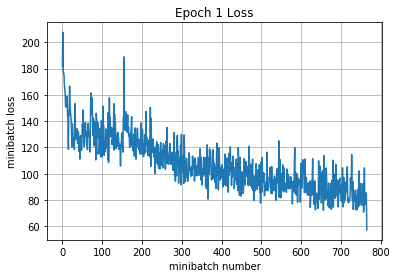

Iteration 800: with minibatch training loss = 1.4 and accuracy of 0.5
Iteration 900: with minibatch training loss = 1.22 and accuracy of 0.58
Iteration 1000: with minibatch training loss = 1.24 and accuracy of 0.53
Iteration 1100: with minibatch training loss = 1.41 and accuracy of 0.53
Iteration 1200: with minibatch training loss = 1.43 and accuracy of 0.55
Iteration 1300: with minibatch training loss = 1.06 and accuracy of 0.61
Iteration 1400: with minibatch training loss = 1.05 and accuracy of 0.64
Iteration 1500: with minibatch training loss = 1.05 and accuracy of 0.64
Epoch 2, Overall loss = 1.13 and accuracy of 0.6


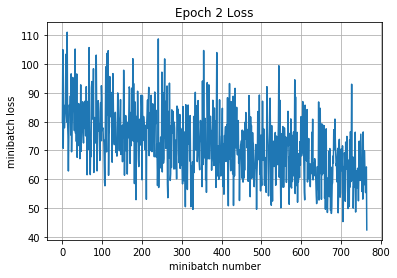

Iteration 1600: with minibatch training loss = 0.863 and accuracy of 0.72
Iteration 1700: with minibatch training loss = 1.12 and accuracy of 0.61
Iteration 1800: with minibatch training loss = 0.791 and accuracy of 0.66
Iteration 1900: with minibatch training loss = 1.24 and accuracy of 0.59
Iteration 2000: with minibatch training loss = 0.779 and accuracy of 0.62
Iteration 2100: with minibatch training loss = 0.895 and accuracy of 0.69
Iteration 2200: with minibatch training loss = 0.765 and accuracy of 0.75
Epoch 3, Overall loss = 0.898 and accuracy of 0.684


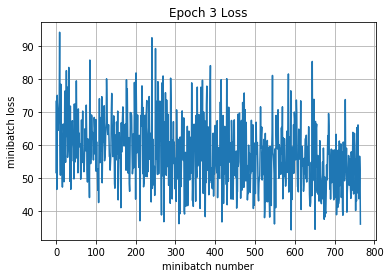

Iteration 2300: with minibatch training loss = 0.708 and accuracy of 0.77
Iteration 2400: with minibatch training loss = 0.822 and accuracy of 0.77
Iteration 2500: with minibatch training loss = 0.999 and accuracy of 0.69
Iteration 2600: with minibatch training loss = 0.564 and accuracy of 0.84
Iteration 2700: with minibatch training loss = 0.98 and accuracy of 0.66
Iteration 2800: with minibatch training loss = 0.666 and accuracy of 0.75
Iteration 2900: with minibatch training loss = 0.599 and accuracy of 0.83
Iteration 3000: with minibatch training loss = 0.458 and accuracy of 0.88
Epoch 4, Overall loss = 0.758 and accuracy of 0.735


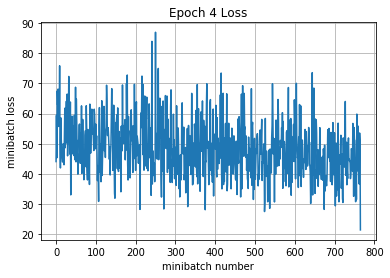

Iteration 3100: with minibatch training loss = 0.941 and accuracy of 0.66
Iteration 3200: with minibatch training loss = 0.678 and accuracy of 0.77
Iteration 3300: with minibatch training loss = 0.569 and accuracy of 0.78
Iteration 3400: with minibatch training loss = 0.682 and accuracy of 0.75
Iteration 3500: with minibatch training loss = 0.72 and accuracy of 0.8
Iteration 3600: with minibatch training loss = 0.463 and accuracy of 0.86
Iteration 3700: with minibatch training loss = 0.812 and accuracy of 0.78
Iteration 3800: with minibatch training loss = 0.619 and accuracy of 0.81
Epoch 5, Overall loss = 0.65 and accuracy of 0.775


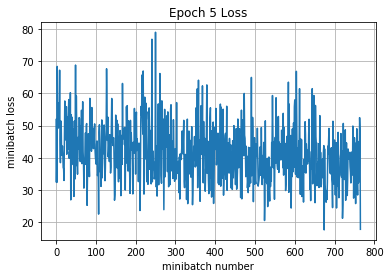

Iteration 3900: with minibatch training loss = 0.401 and accuracy of 0.89
Iteration 4000: with minibatch training loss = 0.694 and accuracy of 0.72
Iteration 4100: with minibatch training loss = 0.512 and accuracy of 0.84
Iteration 4200: with minibatch training loss = 0.472 and accuracy of 0.83
Iteration 4300: with minibatch training loss = 0.693 and accuracy of 0.77
Iteration 4400: with minibatch training loss = 0.506 and accuracy of 0.81
Iteration 4500: with minibatch training loss = 0.522 and accuracy of 0.77
Epoch 6, Overall loss = 0.556 and accuracy of 0.808


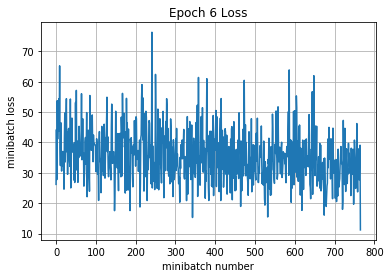

Iteration 4600: with minibatch training loss = 0.558 and accuracy of 0.81
Iteration 4700: with minibatch training loss = 0.338 and accuracy of 0.94
Iteration 4800: with minibatch training loss = 0.56 and accuracy of 0.78
Iteration 4900: with minibatch training loss = 0.379 and accuracy of 0.88
Iteration 5000: with minibatch training loss = 0.479 and accuracy of 0.84
Iteration 5100: with minibatch training loss = 0.412 and accuracy of 0.86
Iteration 5200: with minibatch training loss = 0.812 and accuracy of 0.7
Iteration 5300: with minibatch training loss = 0.547 and accuracy of 0.8
Epoch 7, Overall loss = 0.478 and accuracy of 0.833


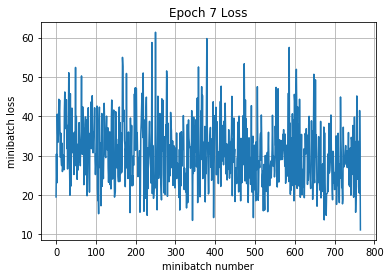

Iteration 5400: with minibatch training loss = 0.619 and accuracy of 0.78
Iteration 5500: with minibatch training loss = 0.299 and accuracy of 0.88
Iteration 5600: with minibatch training loss = 0.374 and accuracy of 0.86
Iteration 5700: with minibatch training loss = 0.228 and accuracy of 0.89
Iteration 5800: with minibatch training loss = 0.246 and accuracy of 0.86
Iteration 5900: with minibatch training loss = 0.35 and accuracy of 0.86


In [ ]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)